In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!module list

Currently Loaded Modulefiles:
 1) shared                             7) cuda11.2/nsight/11.2.2      
 2) slurm/slurm/20.11.8                8) cuda11.2/fft/11.2.2         
 3) python37                           9) cuda11.2/blas/11.2.2        
 4) jupyter-eg-kernel-wlm-py37/2.0.0  10) cudnn8.1-cuda11.2/8.1.1.33  
 5) cuda11.2/toolkit/11.2.2           11) cuda11.2/11.2.2             
 6) cuda11.2/profiler/11.2.2          
>

In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [3]:
!hostname

gpu008


In [4]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [5]:
#x mean
mu_x  = tf.Variable(80.0, name='x_mean')                       # 
#y mean
mu_y  = tf.Variable(80.0, name='y_mean') 
#x sigma
sig_x = tf.Variable(0.75, name='x_sig')
#y sigma
sig_y = tf.Variable(0.75, name='y_sig')

#define model
@tf.function
def mvn_fit(x):
    mu = [mu_x,mu_y]
    sigma = [sig_x,sig_y]
    gmvn = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma)
    return gmvn.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

2022-04-27 09:17:31.307297: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 09:17:32.808900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-04-27 09:17:32.814877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30989 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [6]:
def mvn_set(x,mu,sigma):
    gmvn = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma)
    return gmvn.prob(x)

In [8]:
nx = 161
ny = 161
xl = np.arange(nx,dtype=np.float32)
yl = np.arange(ny,dtype=np.float32)
xl += 0.5
yl += 0.5
x,y = np.meshgrid(xl,yl)
#x += 0.5
#y += 0.5
xy = np.dstack((x,y))
print(xy.shape)
print(xl[80])


(161, 161, 2)
80.5


In [9]:
mu = np.array([0.5*nx,0.5*ny])
Sigma = np.array([10.,8.])
gg = np.reshape(mvn_set(xy,mu,Sigma),(nx,ny))
print(type(gg[0,0]))

<class 'numpy.float64'>


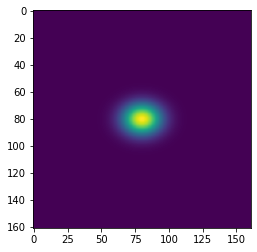

In [10]:
plt.imshow(gg)

In [11]:
#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_fit(xy)
        loss = mse(pred, gg)
        print(f"Epoch {epoch} | Loss {loss.numpy()}, mu_x: {mu_x.numpy()} mu_y:{mu_y.numpy()} s_x:{sig_x.numpy()} s_y:{sig_y.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_fit(xy)
        loss = mse(gg,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [mu_x,mu_y,sig_x,sig_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[mu_x,mu_y,sig_x,sig_y]))

[W 2022-04-27 09:18:23,643.643 tensorflow] From /cm/local/apps/python37/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py:342: calling MultivariateNormalDiag.__init__ (from tensorflow_probability.python.distributions.mvn_diag) with scale_identity_multiplier is deprecated and will be removed after 2020-01-01.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Epoch 0 | Loss 0.000846835202537477, mu_x: 80.0 mu_y:80.0 s_x:0.75 s_y:0.75
Epoch 1000 | Loss 0.00024155000573955476, mu_x: 80.2718505859375 mu_y:80.33230590820312 s_x:1.380207896232605 s_y:1.380087971687317
Epoch 2000 | Loss 0.00013869465328752995, mu_x: 80.44401550292969 mu_y:80.47720336914062 s_x:1.778748631477356 s_y:1.7781989574432373
Epoch 3000 | Loss 9.195644088322297e-05, mu_x: 80.48958587646484 mu_y:80.498046875 s_x:2.1288201808929443 s_y:2.1274001598358154
Epoch 4000 | Loss 6.437929550884292e-05, mu_x: 80.49801635742188 mu_y:80.49861907958984 s_x:2.469773292541504 s_y:2.466805934906006
Epoch 5000 | Loss 4.607755545293912e-05, mu_x: 80.49801635742188 mu_y:80.49864196777344 s_x:2.8185882568359375 s_y:2.8130180835723877
Epoch 6000 | Loss 3.3186304790433496e-05, mu_x: 80.49801635742188 mu_y:80.49864959716797 s_x:3.1842727661132812 s_y:3.174534797668457
Epoch 7000 | Loss 2.3832237275200896e-05, mu_x: 80.49801635742188 mu_y:80.49864959716797 s_x:3.571669340133667 s_y:3.555518150329

In [12]:
print(f" Loss {loss.numpy()}, mu_x: {mu_x.numpy()} mu_y:{mu_y.numpy()} s_x:{sig_x.numpy()} s_y:{sig_y.numpy()}")


 Loss 2.501180951242077e-08, mu_x: 80.49801635742188 mu_y:80.49864959716797 s_x:9.2605619430542 s_y:8.181253433227539


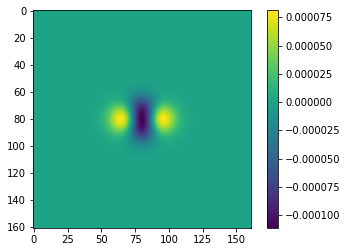

In [15]:
plt.imshow(gg-pred)
plt.colorbar()

In [63]:
#Try two gaussians

In [16]:
mu = np.array([0.5*nx,0.5*ny])
Sigma_a = np.array([2.,2.5])
Sigma_b = np.array([10.,15.])
mu = np.array([0.5*nx,0.5*ny])
gg = np.reshape(mvn_set(xy,mu,Sigma_a)+mvn_set(xy,mu,Sigma_b),(nx,ny)) 
print(type(gg[0,0]))

<class 'numpy.float64'>


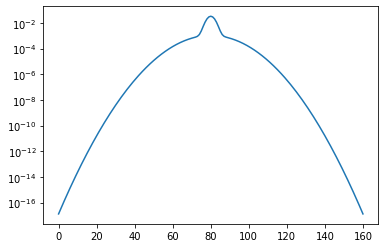

In [17]:
plt.plot(gg[80,:])
plt.yscale('log')

In [18]:
#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)

    return gmvn_a.prob(x)+gmvn_b.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [20]:
#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_two_fit(xy)
        loss = mse(pred, gg)
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_two_fit(xy)
        loss = mse(gg,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

Epoch 0 | Loss 2.297982427990064e-05 s_x_a:1.65993070602417 s_y_a:1.6977349519729614 s_x_b:10.50881290435791 s_y_b:10.717597961425781
Epoch 1000 | Loss 5.356369001674466e-06 s_x_a:1.8959617614746094 s_y_a:2.001680374145508 s_x_b:10.785309791564941 s_y_b:11.249617576599121
Epoch 2000 | Loss 1.3336359643290052e-06 s_x_a:2.0112080574035645 s_y_a:2.210259199142456 s_x_b:10.91347885131836 s_y_b:11.708765029907227
Epoch 3000 | Loss 3.672951720545825e-07 s_x_a:2.0424513816833496 s_y_a:2.3530771732330322 s_x_b:10.931828498840332 s_y_b:12.11320972442627
Epoch 4000 | Loss 1.2227395984609757e-07 s_x_a:2.026340961456299 s_y_a:2.442317008972168 s_x_b:10.886669158935547 s_y_b:12.475210189819336
Epoch 5000 | Loss 6.1494738190504e-08 s_x_a:2.006436824798584 s_y_a:2.4873342514038086 s_x_b:10.813511848449707 s_y_b:12.801633834838867
Epoch 6000 | Loss 4.317091040206833e-08 s_x_a:1.9996180534362793 s_y_a:2.5010836124420166 s_x_b:10.728960037231445 s_y_b:13.095846176147461
Epoch 7000 | Loss 3.1507280340292

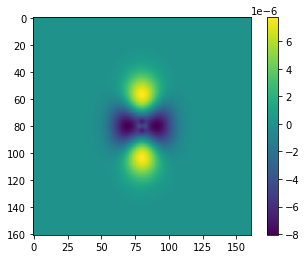

In [21]:
plt.imshow(gg-pred)
plt.colorbar()

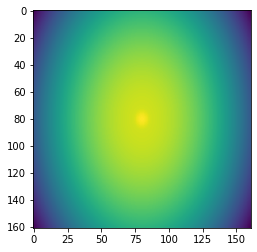

In [22]:
plt.imshow(np.log10(gg))

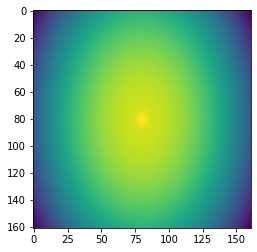

In [23]:
plt.imshow(np.log10(pred))

In [24]:
!python3 -m pip list | grep webbpsf

webbpsf                           1.0.0
You should consider upgrading via the '/cm/local/apps/python37/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!python3 -m pip install webbpsf

In [26]:
!python3 -m pip install astropy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.7 MB 6.6 MB/s eta 0:00:01�█████████████████████▉         | 7.6 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 746 kB 133.1 MB/s eta 0:00:01
You should consider upgrading via the '/cm/local/apps/python37/bin/python3 -m pip install --upgrade pip' command.


In [29]:
!export WEBBPSF_PATH=/data/groups/comp-astro/jades/webbpsf-data 

In [30]:
import os

In [31]:
os.environ["WEBBPSF_PATH"] = "/data/groups/comp-astro/jades/webbpsf-data"

In [32]:
!echo $WEBBPSF_PATH

/data/groups/comp-astro/jades/webbpsf-data


In [33]:
import webbpsf

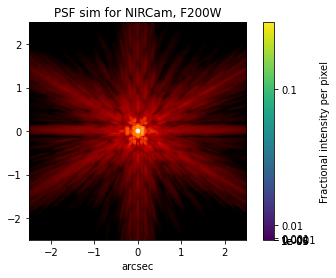

In [34]:
nc = webbpsf.NIRCam()
nc.filter = 'F200W'
psf = nc.calc_psf(detector_oversample=1,fft_oversample=4)
plt.imshow(psf[0].data)
webbpsf.display_psf(psf)

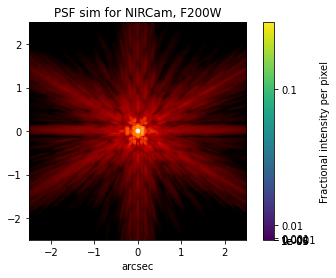

In [35]:
nc = webbpsf.NIRCam()
nc.filter = 'F200W'
psf = nc.calc_psf(detector_oversample=1,fft_oversample=4)
plt.imshow(psf[0].data)
webbpsf.display_psf(psf)

In [36]:
psf_data = psf[0].data

In [37]:
print(psf_data.shape)

(161, 161)


In [39]:
#amp
amp = tf.Variable(0.5, name='amp')

#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)

    return amp*gmvn_a.prob(x)+(1.-amp)*gmvn_b.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [40]:
#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_two_fit(xy)
        loss = mse(psf_data,pred)
        print(f"Epoch {epoch} | Loss {loss.numpy()} amp:{amp.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_two_fit(xy)
        loss = mse(psf_data,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [amp,sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[amp,sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

Epoch 0 | Loss 5.362015144783072e-05 amp:0.5 s_x_a:1.0 s_y_a:1.0 s_x_b:10.0 s_y_b:10.0
Epoch 1000 | Loss 5.386983502830844e-06 amp:0.6771688461303711 s_x_a:0.8467398285865784 s_y_a:0.8593774437904358 s_x_b:9.786336898803711 s_y_b:9.770062446594238
Epoch 2000 | Loss 5.35805884283036e-06 amp:0.6767492890357971 s_x_a:0.8465309143066406 s_y_a:0.8591645956039429 s_x_b:9.509998321533203 s_y_b:9.469335556030273
Epoch 3000 | Loss 5.322780907590641e-06 amp:0.6760467886924744 s_x_a:0.846141517162323 s_y_a:0.8587697744369507 s_x_b:9.19122314453125 s_y_b:9.12236213684082
Epoch 4000 | Loss 5.282294750941219e-06 amp:0.675212025642395 s_x_a:0.8456796407699585 s_y_a:0.8583018779754639 s_x_b:8.847630500793457 s_y_b:8.747387886047363
Epoch 5000 | Loss 5.236729975877097e-06 amp:0.674226701259613 s_x_a:0.8451359868049622 s_y_a:0.8577517867088318 s_x_b:8.485675811767578 s_y_b:8.350760459899902
Epoch 6000 | Loss 5.1859001359844115e-06 amp:0.673062264919281 s_x_a:0.8444955945014954 s_y_a:0.8571042418479919 s

-8.093935829214276 -0.8415539081671065


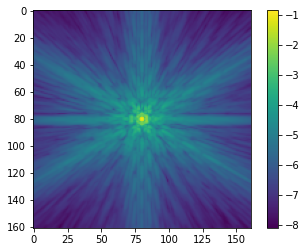

In [41]:
plt.imshow(np.log10(psf_data))
print(np.min(np.log10(psf_data)),np.max(np.log10(psf_data)))
plt.colorbar()

__main__:1: RuntimeWarning: divide by zero encountered in log10


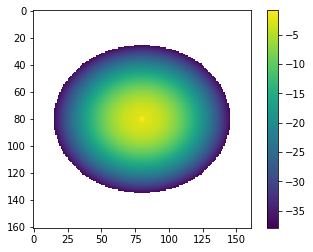

In [42]:
plt.imshow(np.log10(pred))
plt.colorbar()

__main__:2: RuntimeWarning: divide by zero encountered in log10


(-10.0, 0.0)

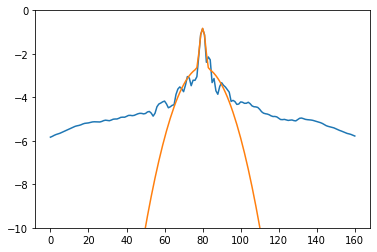

In [43]:
plt.plot(np.log10(psf_data[80,:]))
plt.plot(np.log10(pred[80,:]))
plt.ylim([-10,0])

__main__:2: RuntimeWarning: divide by zero encountered in log10


(-10.0, 0.0)

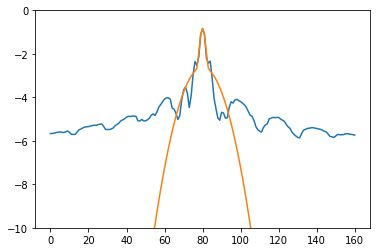

In [44]:
plt.plot(np.log10(psf_data[:,80]))
plt.plot(np.log10(pred[:,80]))
plt.ylim([-10,0])

In [45]:
#amp
amp_a = tf.Variable(0.5, name='amp_a')

#amp
amp_b = tf.Variable(0.25, name='amp_b')

#amp
amp_c = tf.Variable(0.05, name='amp_c')

#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

#sig x c
sig_x_c  = tf.Variable(20.0, name='sig_x_c')                       # 
#sig y c
sig_y_c  = tf.Variable(20.0, name='sig_y_c')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]
    sigma_c = [sig_x_c,sig_y_c]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)
    gmvn_c = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_c)

    return tf.math.abs(amp_a)*gmvn_a.prob(x)+tf.math.abs(amp_b)*gmvn_b.prob(x)+tf.math.abs(amp_c)*gmvn_c.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

@tf.function
def mse_log(y_true_in, y_pred_in):
    return loss_fn(y_true=tf.math.log(y_true_in),y_pred=tf.math.log(y_pred_in))

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [46]:
#start training
klam = 1.0e6
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_three_fit(xy)
#        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)

        print(f"Epoch {epoch} | Loss {loss.numpy()} amp_a:{amp_a.numpy()} amp_b:{amp_b.numpy()} amp_c:{amp_c.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()} s_x_c:{sig_x_c.numpy()} s_y_c:{sig_y_c.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_three_fit(xy)
#        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [amp_a,amp_b,amp_c,sig_x_a,sig_y_a,sig_x_b,sig_y_b,sig_x_c,sig_y_c])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[amp_a,amp_b,amp_c,sig_x_a,sig_y_a,sig_x_b,sig_y_b,sig_x_c,sig_y_c]))

Epoch 0 | Loss 1513.8546142578125 amp_a:0.5 amp_b:0.25 amp_c:0.05000000074505806 s_x_a:1.0 s_y_a:1.0 s_x_b:10.0 s_y_b:10.0 s_x_c:20.0 s_y_c:20.0
Epoch 1000 | Loss 692.5671997070312 amp_a:0.6894079446792603 amp_b:0.00017963710706681013 amp_c:0.26414695382118225 s_x_a:0.8559169173240662 s_y_a:0.8686662316322327 s_x_b:9.811483383178711 s_y_b:9.82666015625 s_x_c:20.798891067504883 s_y_c:20.72877311706543
Epoch 2000 | Loss 591.0145263671875 amp_a:0.6908637881278992 amp_b:7.801499305060133e-05 amp_c:0.20947836339473724 s_x_a:0.8573092818260193 s_y_a:0.8700233101844788 s_x_b:9.807819366455078 s_y_b:9.823643684387207 s_x_c:21.553375244140625 s_y_c:21.383161544799805
Epoch 3000 | Loss 506.494384765625 amp_a:0.6907860636711121 amp_b:-0.014909081161022186 amp_c:0.15912774205207825 s_x_a:0.8572038412094116 s_y_a:0.8699225783348083 s_x_b:9.454042434692383 s_y_b:9.51197624206543 s_x_c:22.33671760559082 s_y_c:22.083282470703125
Epoch 4000 | Loss 437.8367614746094 amp_a:0.6884675621986389 amp_b:-0.038

(-10.0, 0.0)

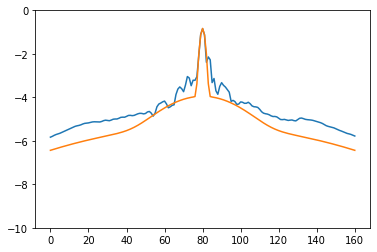

In [47]:
plt.plot(np.log10(psf_data[80,:]))
plt.plot(np.log10(pred[80,:].numpy()))
plt.ylim([-10,0])

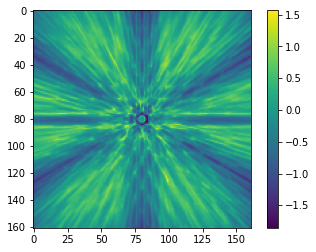

In [50]:
plt.imshow(np.log10(pred)-np.log10(psf_data))
plt.colorbar()

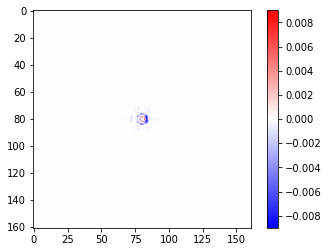

In [55]:
plt.imshow(pred-psf_data,vmin=-0.009,vmax=0.009,cmap='bwr')
plt.colorbar()

In [52]:
def tukey(x,lam,a):
    # Def 4.3 of 1901.04365

    def tukey_trans(fx,a,lam):
        return 0.5*(1-np.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    
    al = (1.0-a)*lam
    fx = np.fabs(x)
    if(isinstance(x,float)):
        y = 0.0
        if(fx<al):
            y = 1.0
        elif(fx<=lam):
            y = tukey_trans(fx,a,lam)
    else:
        y = np.zeros_like(x)
         
        #inner bump
        xs = x[fx<al]
        y[fx<al] = 1.
        
        #transition
        xl = x[(fx>=al)&(fx<=lam)]
        y[(fx>=al)&(fx<=lam)] = tukey_trans(fx[(fx>=al)&(fx<=lam)],a,lam)
    return y

In [45]:
#amp
amp_a = tf.Variable(0.5, name='amp_a')

#amp
amp_b = tf.Variable(0.25, name='amp_b')

#amp
amp_c = tf.Variable(0.05, name='amp_c')

#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

#sig x c
sig_x_c  = tf.Variable(20.0, name='sig_x_c')                       # 
#sig y c
sig_y_c  = tf.Variable(20.0, name='sig_y_c')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]
    sigma_c = [sig_x_c,sig_y_c]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)
    gmvn_c = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_c)

    return tf.math.abs(amp_a)*gmvn_a.prob(x)+tf.math.abs(amp_b)*gmvn_b.prob(x)+tf.math.abs(amp_c)*gmvn_c.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

@tf.function
def mse_log(y_true_in, y_pred_in):
    return loss_fn(y_true=tf.math.log(y_true_in),y_pred=tf.math.log(y_pred_in))

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
#apply tukey bump function to 

In [159]:
#define model
@tf.function
def model_function(x):
    
    #initial 3 gaussian approximation
    gapp = mvn_three_fit(x)
    
    #take fourier transform
    gapp_fft = tf.signal.fft2d(gapp)
    
    return gcomp
    
    

In [160]:
#start training
klam = 1.0e6
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = model_function(xy)
        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
#        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)

        print(f"Epoch {epoch} | Loss {loss.numpy()} amp_a:{amp_a.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = model_function(xy)
        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
#        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [amp_a,sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[amp_a,sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

Epoch 0 | Loss 5.5345164582831785e-05 amp_a:0.5 s_x_a:1.0 s_y_a:1.0 s_x_b:20.0 s_y_b:20.0
Epoch 1000 | Loss 5.864741979166865e-06 amp_a:0.6843382120132446 s_x_a:0.8507255911827087 s_y_a:0.8634271621704102 s_x_b:19.93864631652832 s_y_b:19.935131072998047
Epoch 2000 | Loss 5.863028036401374e-06 amp_a:0.6845124363899231 s_x_a:0.8508569002151489 s_y_a:0.8635590672492981 s_x_b:19.85904884338379 s_y_b:19.850494384765625
Epoch 3000 | Loss 5.861129011464072e-06 amp_a:0.6844881176948547 s_x_a:0.850843071937561 s_y_a:0.8635450005531311 s_x_b:19.771150588989258 s_y_b:19.757080078125
Epoch 4000 | Loss 5.859134944330435e-06 amp_a:0.68446284532547 s_x_a:0.8508287668228149 s_y_a:0.8635305762290955 s_x_b:19.67995262145996 s_y_b:19.660093307495117
Epoch 5000 | Loss 5.857070846104762e-06 amp_a:0.6844370365142822 s_x_a:0.8508142232894897 s_y_a:0.8635156154632568 s_x_b:19.586524963378906 s_y_b:19.560911178588867
Epoch 6000 | Loss 5.854949449712876e-06 amp_a:0.6844106316566467 s_x_a:0.8507993817329407 s_y_

KeyboardInterrupt: 

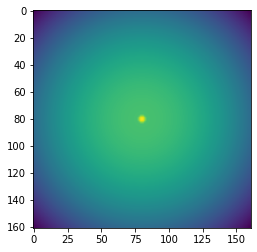

In [162]:
plt.imshow(np.log10(pred))

(-10.0, 0.0)

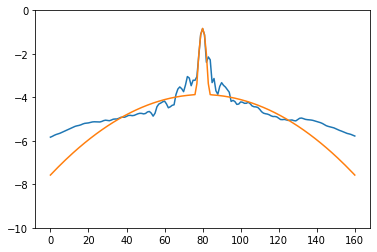

In [163]:
plt.plot(np.log10(psf_data[80,:]))
plt.plot(np.log10(pred[80,:].numpy()))
plt.ylim([-10,0])

In [165]:
pred_fft = tf.signal.fft2d(tf.cast(pred,dtype=tf.complex64))

In [174]:
print((np.absolute(pred_fft.numpy()).shape))

(161, 161)


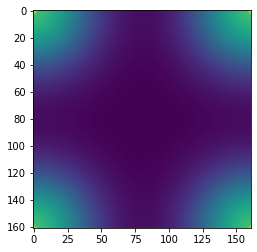

In [166]:
plt.imshow(tf.abs(pred_fft))

In [167]:
pred_ifft = tf.signal.ifft2d(pred_fft)

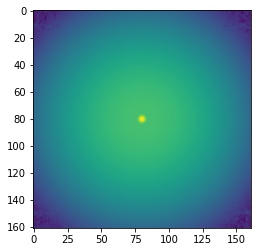

In [169]:
plt.imshow(np.log10(tf.abs(pred_ifft)))